In [1]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.2 MB/s eta 0:00:00


In [3]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import evaluate

seed = 42
from datasets import Dataset
from datasets import load_dataset
import datasets
from torch import nn
import torch

2024-05-29 09:39:34.456983: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 09:39:34.457089: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 09:39:34.573641: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
dataset = load_dataset("FartLabs/FartDB")

Generating train split:   0%|          | 0/13634 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2922 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2922 [00:00<?, ? examples/s]

In [5]:
train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

In [6]:
exclude_idx = [9438, 8508]

# create new dataset exluding those idx
train_dataset = train_dataset.select(
    (
        i for i in range(len(train_dataset)) 
        if i not in set(exclude_idx)
    )
)

Parameter 'indices'=<generator object <genexpr> at 0x78ee64066500> of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [7]:
model_checkpoint = "seyonec/PubChem10M_SMILES_BPE_396_250"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_function(examples):
    return tokenizer(examples["Canonicalized SMILES"], padding="max_length", truncation=True, max_length=512)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/515 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/165k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/101k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Map:   0%|          | 0/13632 [00:00<?, ? examples/s]

Map:   0%|          | 0/2922 [00:00<?, ? examples/s]

Map:   0%|          | 0/2922 [00:00<?, ? examples/s]

In [10]:
label_encoder = LabelEncoder()

In [29]:
encoded_labels = label_encoder.fit_transform(train_dataset['Canonicalized Flavor'])
train_dataset.add_column('label', encoded_labels)
encoded_labels = label_encoder.fit_transform(test_dataset['Canonicalized Flavor'])
test_dataset.add_column('label', encoded_labels)
encoded_labels = label_encoder.fit_transform(val_dataset['Canonicalized Flavor'])
val_dataset.add_column('label', encoded_labels)

In [22]:
# Optional if you want to push something
from huggingface_hub import notebook_login

notebook_login()

In [12]:
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [13]:
from collections import Counter

label_counts = Counter(train_dataset['label'])
num_labels = 5
classes = range(num_labels)
weights = {label: 1 / label_counts[label] for label in classes if label in label_counts}

total_weight = sum(weights.values())
weights_normalized = {label: weight / total_weight for label, weight in weights.items()}

weights_ordered = np.array([weights_normalized[label] for label in classes])

In [36]:
num_labels = 5
model_checkpoint = "FartLabs/FART_Chemberta_PubChem10M"
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    evaluation_strategy="steps",
    logging_dir="./logs",
    save_strategy="steps",
    load_best_model_at_end=True,
    save_total_limit=5,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [12]:
# CustomTrainer if you want to weight in loss function (ask Yoel)
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        device = model.module.device
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(weights_ordered, dtype=torch.float32, device=device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [19]:
trainer.train()

Step,Training Loss,Validation Loss
500,1.106900,1.149582
1000,0.968100,0.931108
1500,0.878300,0.971645
2000,0.846200,0.944957
2500,0.791900,0.903650
3000,0.735200,0.953094
3500,0.749300,0.925381
4000,0.615200,0.954406
4500,0.646000,0.972398
5000,0.630900,0.982341


TrainOutput(global_step=8520, training_loss=0.6577915590134025, metrics={'train_runtime': 3008.2248, 'train_samples_per_second': 22.658, 'train_steps_per_second': 2.832, 'total_flos': 9029460949401600.0, 'train_loss': 0.6577915590134025, 'epoch': 5.0})

In [21]:
results = trainer.evaluate(eval_dataset=val_dataset)
print(results)

{'eval_loss': 0.9036503434181213, 'eval_runtime': 32.7009, 'eval_samples_per_second': 89.355, 'eval_steps_per_second': 11.192, 'epoch': 5.0}


In [38]:
predictions = trainer.predict(test_dataset)

In [39]:
import numpy as np
from scipy.special import softmax

# Convert logits to probabilities
probs = softmax(predictions.predictions, axis=1)

# Get the predicted labels
pred_labels = np.argmax(probs, axis=1)

# Get the true labels
true_labels = predictions.label_ids


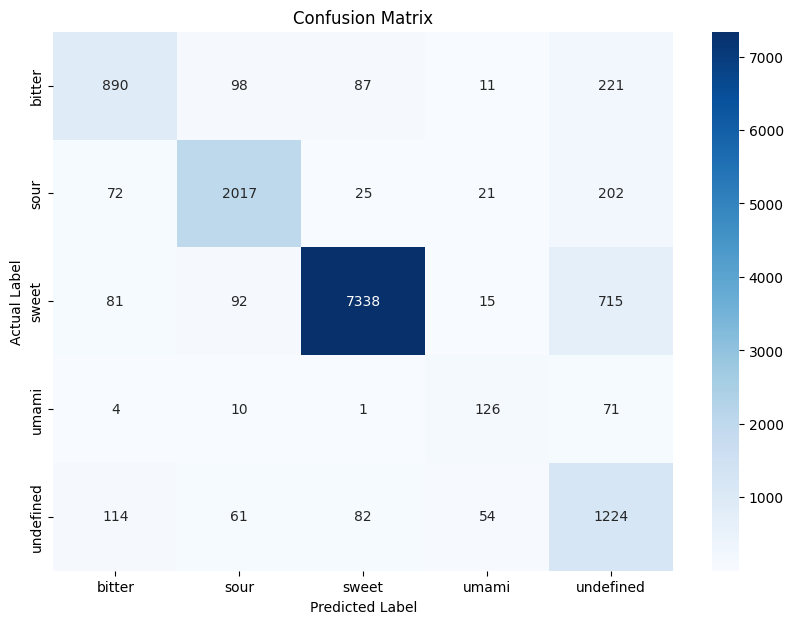

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(true_labels, pred_labels)

label_names = label_encoder.inverse_transform(range(5))

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


In [33]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Calculate accuracy
accuracy = accuracy_score(true_labels, pred_labels)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8506
Precision: 0.8795
Recall: 0.8506
F1 Score: 0.8599


In [40]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Calculate accuracy
accuracy = accuracy_score(true_labels, pred_labels)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision, recall, and F1 score for each class
precision, recall, f1, support = precision_recall_fscore_support(true_labels, pred_labels)

# Optionally, if you want to calculate the weighted scores as well
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')
print(f"Weighted Precision: {precision_weighted:.4f}")
print(f"Weighted Recall: {recall_weighted:.4f}")
print(f"Weighted F1 Score: {f1_weighted:.4f}")
class_names = label_encoder.classes_

# Print the scores for each class with class names
for i, (p, r, f, s) in enumerate(zip(precision, recall, f1, support)):
    print(f"Class {class_names[i]}:")
    print(f"  Precision: {p:.4f}")
    print(f"  Recall: {r:.4f}")
    print(f"  F1 Score: {f:.4f}")
    print(f"  Support: {s}")

Accuracy: 0.8381
Weighted Precision: 0.8348
Weighted Recall: 0.8381
Weighted F1 Score: 0.8347
Class bitter:
  Precision: 0.7087
  Recall: 0.5906
  F1 Score: 0.6443
  Support: 276
Class sour:
  Precision: 0.8450
  Recall: 0.8067
  F1 Score: 0.8254
  Support: 507
Class sweet:
  Precision: 0.9132
  Recall: 0.9476
  F1 Score: 0.9301
  Support: 1755
Class umami:
  Precision: 0.5556
  Recall: 0.2439
  F1 Score: 0.3390
  Support: 41
Class undefined:
  Precision: 0.5528
  Recall: 0.5948
  F1 Score: 0.5730
  Support: 343


In [23]:
trainer.model.push_to_hub("FartLabs/FART_Chemberta_PubChem10M_weighted")

model.safetensors:   0%|          | 0.00/334M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/FartLabs/FART_Chemberta_PubChem10M_weighted/commit/b0dfee294a4e7744079892d8e9aefae1e1b54be0', commit_message='Upload RobertaForSequenceClassification', commit_description='', oid='b0dfee294a4e7744079892d8e9aefae1e1b54be0', pr_url=None, pr_revision=None, pr_num=None)

In [24]:
tokenizer.push_to_hub("FartLabs/FART_Chemberta_PubChem10M_weighted")

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/FartLabs/FART_Chemberta_PubChem10M_weighted/commit/bc9d5ecf702f0048d4d07a58eb01a6daf3585ae9', commit_message='Upload tokenizer', commit_description='', oid='bc9d5ecf702f0048d4d07a58eb01a6daf3585ae9', pr_url=None, pr_revision=None, pr_num=None)

In [29]:
label_names

array(['bitter', 'sour', 'sweet', 'umami', 'undefined'], dtype='<U9')

In [30]:
test_dataset

Dataset({
    features: ['Canonicalized SMILES', 'Canonicalized Flavor', 'Original Labels', 'Source', 'input_ids', 'attention_mask', 'label'],
    num_rows: 2922
})

In [11]:
test_dataset

Dataset({
    features: ['Canonicalized SMILES', 'Canonicalized Flavor', 'Original Labels', 'Source', 'label'],
    num_rows: 2922
})

model.safetensors:   0%|          | 0.00/334M [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


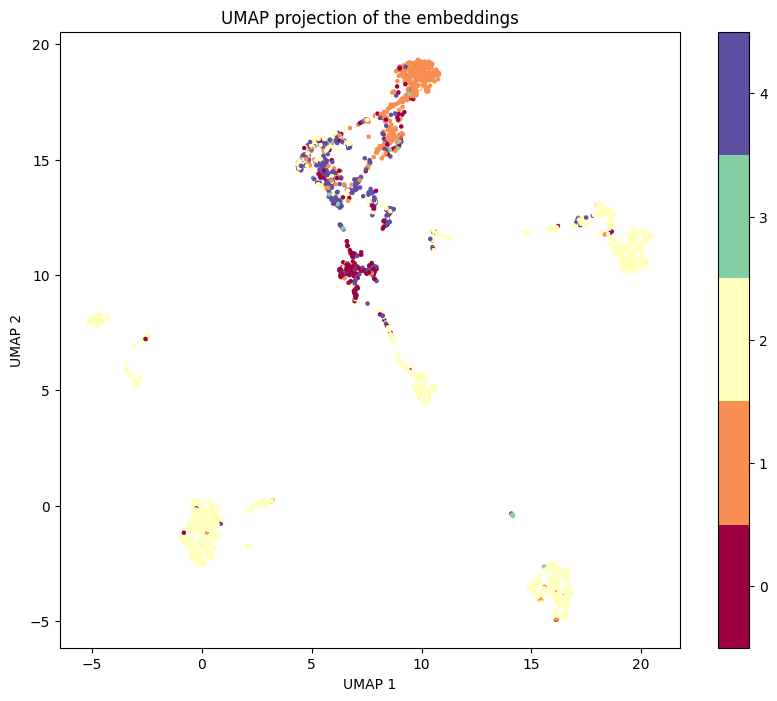

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import umap
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from torch.utils.data import DataLoader, Dataset


dataset = test_dataset

tokenizer = AutoTokenizer.from_pretrained("seyonec/PubChem10M_SMILES_BPE_396_250")
model = AutoModelForSequenceClassification.from_pretrained("FartLabs/FART_Chemberta_PubChem10M", output_hidden_states=True)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

class TextDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

# Function to get embeddings
def get_embeddings(dataloader):
    all_embeddings = []
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            inputs = tokenizer(batch, padding=True, truncation=True, return_tensors='pt')
            inputs = {key: value.to(device) for key, value in inputs.items()}  # Move inputs to the same device as the model
            outputs = model(**inputs)
            # Get the embeddings from the hidden states
            hidden_states = outputs.hidden_states[-1]  # Using the last hidden state
            embeddings = hidden_states[:, 0, :].cpu().numpy()  # Move the embeddings back to CPU for UMAP
            all_embeddings.append(embeddings)
    return np.vstack(all_embeddings)

# Get the text and labels from the dataset
texts = dataset['Canonicalized SMILES']  # Replace with your text column name
labels = dataset['label']

# Create DataLoader for batching
batch_size = 16  # Adjust this based on your GPU memory
text_dataset = TextDataset(texts)
dataloader = DataLoader(text_dataset, batch_size=batch_size, shuffle=False)

# Get embeddings for the dataset
embeddings = get_embeddings(dataloader)

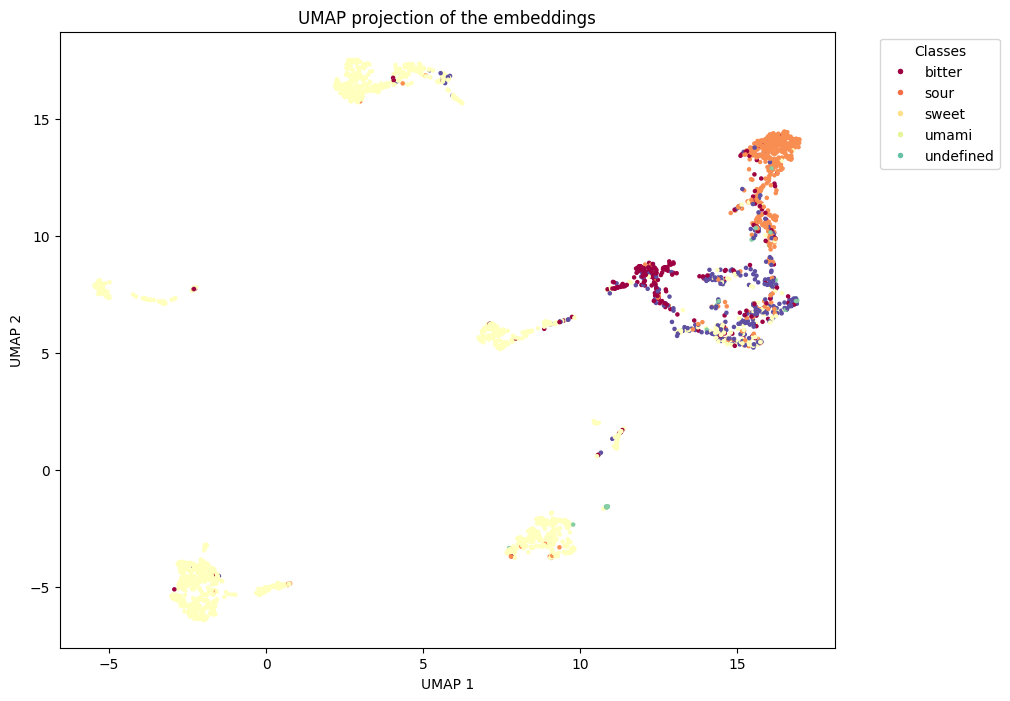

In [22]:
# Perform UMAP
reducer = umap.UMAP(n_components=2, n_neighbors=20, min_dist=0.1)
umap_embeddings = reducer.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=labels, cmap='Spectral', s=5)
plt.title('UMAP projection of the embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Create a legend with class names
classes = label_encoder.classes_
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.Spectral(i / len(classes)), markersize=5) for i in range(len(classes))]
plt.legend(handles, classes, title="Classes", loc='best', bbox_to_anchor=(1.05, 1))
plt.show()
